INTRODUCTION:

In this notebook, we discuss two examples of topological data analysis (TDA) techniques being used for image analysis. We then perform an analysis of the MNIST database of handwritten digits (http://yann.lecun.com/exdb/mnist/) using similar techniques that categorizes them based on their topological information. 

TDA gives us a way to compute approximate topological information in data sets --- including images. The topological information of an object $X$ can be summarized by number of holes with a $k$-dimensional boundary in the object (mathematically, the dimension of the $k^{th}$-Homology group $H_k(X)$). The cases $k = 0$ and $k = 1$ correspond to the number of connected components of $X$ and the number of holes in $X$ (like a donut). 

Note: While many data analysis tools are strongly geometric in nature, topological information like the number of connected components and holes of $X$ is independent of the geometry of $X$.

For images analysis, this topological information could be used to count the number of cells in a miscoscope image (see Example 2) or to distinguish between nuts and bolts (see Example 1).

In [76]:
%run TDA_helper_functions.ipynb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.linalg as la
import pandas as pd
import hdbscan
import imageio


from ripser import ripser, lower_star_img
from persim import plot_diagrams
from scipy import sparse
from sklearn.decomposition import PCA

EXAMPLE 1 --- NUTS & BOLTS:

In the first example, we run the function lower_star_img_new() on an image of nuts and bolts. This function computes topological information of the sublevelset filtration of an image. The sublevelset filtration is the set $X_t = \{x : f(x) \leq t\}$, where 
$$f : \{0,1,\dots,M\} \times \{0,1,\dots,N\} \to \{0,1,2,\dots,255\},$$ 
is the function that assigns a pixel value to each pixel location (the images are 8-bit and have dimensions $M \times N$). 

The output of lower_star_img_new() is 2 lists of birth-death points $(b,d)$ in $\mathbb{R}^2$ called $H_0$ and $H_1$ persistence diagrams (PDs). The $H_0$ PD describes the birth and death of the connected components of $X_t$ and the $H_1$ PD describes the birth and death of the holes in the image of $X_t$, as the parameter $t$ varies.

The points in the PDs with long lifetimes (i.e. those where $d-b$ is large) will distinguish the nuts (that are oriented so you can see through the hole) from the bolts. The image of the nuts and bolts comes from the paper "Persistence Curves: A Canonical Framework For Summarizing Persistence Diagrams" by Chung and Lawson (see Figure 1).

There are 8 H_0 points with long lifetimes.
There are 4 H_1 points with long lifetimes.


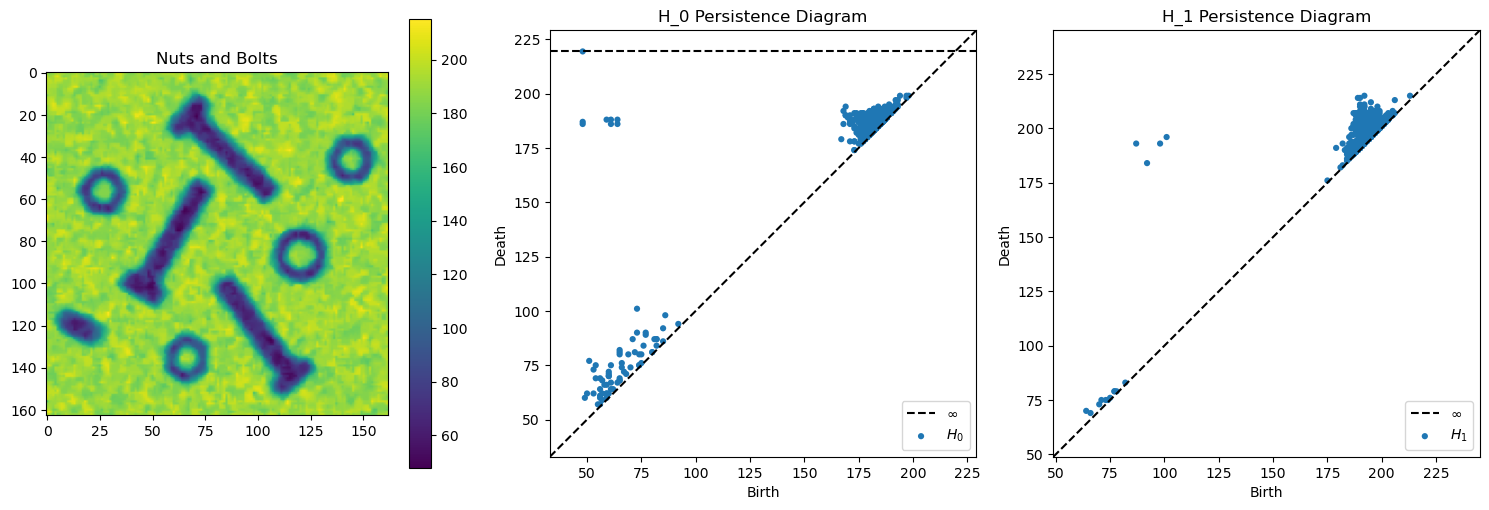

In [77]:
#Example 1: nuts and bolts example

NB = imageio.imread('TDA_Nuts_Bolts.png')

NB_im = 255 - NB[:,:,0] #invert image so nuts & bolts appear in sublevelsets
dgm = lower_star_img_new(NB_im)

dgm0 = dgm[0] #H_0 persistence diagram
dgm1 = dgm[1] #H_1 persistence diagram


#make a lists of H0 and H1-points with long lifetimes (longer that 30) to eliminate the noise
thresh = 30

H0_pts = []
for pt in dgm0:
    if pt[1] - pt[0] > thresh:
        H0_pts.append(pt)
print('There are ' + str(len(H0_pts)) + ' H_0 points with long lifetimes.')
        
H1_pts = []
for pt in dgm1:
    if pt[1] - pt[0] > thresh:
        H1_pts.append(pt) 
        
print('There are ' + str(len(H1_pts)) + ' H_1 points with long lifetimes.')

#Plot image and persistence diagrams
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(NB_im)
plt.colorbar()
plt.title("Nuts and Bolts")

plt.subplot(132)
plot_diagrams(dgm0)
plt.title("H_0 Persistence Diagram")

plt.subplot(133)
plot_diagrams(dgm1)
plt.title("H_1 Persistence Diagram")
plt.legend(["$\infty$","$H_1$"], loc = 4)

plt.tight_layout()
plt.show()

Each of the 8 points in the $H_0$-diagram with long lifetimes correspond to one of the 8 nuts and bolts in the image. Each of the 4 points in the $H_1$-diagram with long lifetimes correspond to one of the 4 nuts that are oriented with the hole visible.

EXAMPLE 2 --- PLANT CELLS:

In Example 2, a micrope image of plant cells is analyzed using TDA. The resulting image is one where the individual plant cells are labeled by using the $H_0$-points in the PD. This is in contrast to the previous example where we simply counted the number of $H_0$-points in the PD. This example is taken from the documentation for the lower_star_img() function, which can be found here: https://ripser.scikit-tda.org/en/latest/notebooks/Lower%20Star%20Image%20Filtrations.html

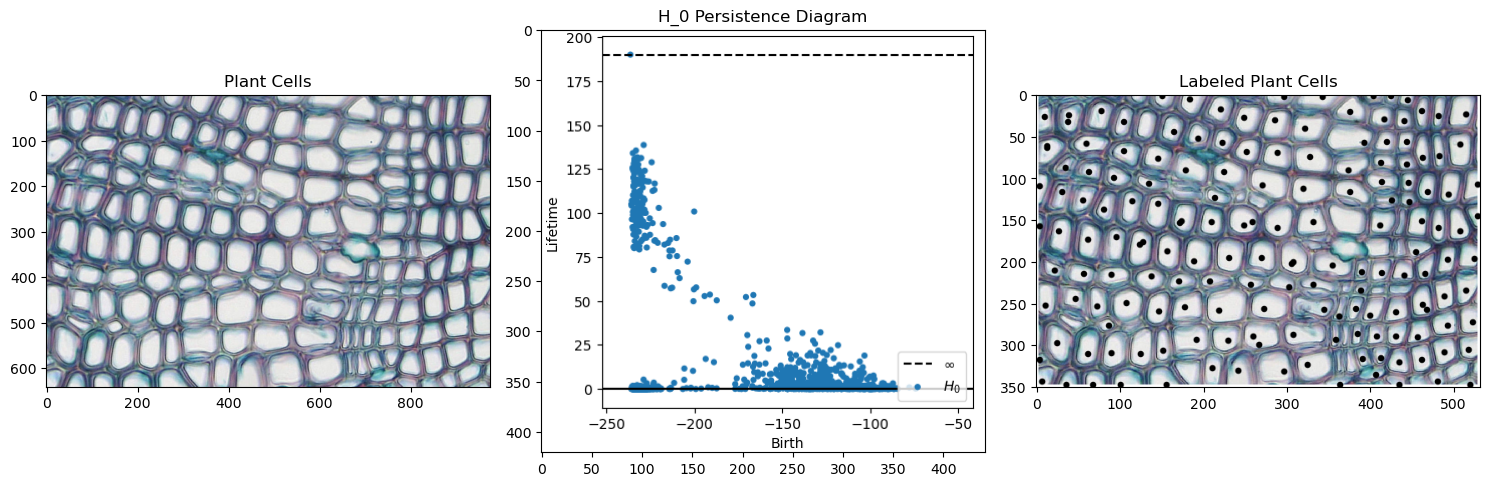

In [78]:
#Example 2: plant cell counting
Cells_im = imageio.imread('TDA_Cells.jpeg')
Cells_Labled_im = imageio.imread('TDA_Cells_Labeled.png')
Cells_PD_im = imageio.imread('Cells_PD.png')

#Plot image and persistence diagrams
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(Cells_im)
plt.title("Plant Cells")

plt.subplot(132)
plt.imshow(Cells_PD_im)
plt.title("H_0 Persistence Diagram")

plt.subplot(133)
plt.imshow(Cells_Labled_im)
plt.title("Labeled Plant Cells")

plt.tight_layout()
plt.show()

In the above example, a microscope image of plant cells (left) is labeled using TDA. Using the lower_star_img() function the 0-Dimensional persistence diagram is generated (middle). The points in the diagram with lifetimes longer than the threshold 70 are used to label the individual cells in the image (right).

ANALYSIS OF MNIST DATABSE OF HANDWRITTEN DIGITS:
    
Now we use TDA to categorize the MNIST database. The $H_0$ PDs will typically only consist of a single point because each digit has a single connected component. Thus, this analysis will focus on understanding the $H_1$ PDs of the images via the following (rough) tricotomy:

1. The digits 1,3,4,5,7 are typically drawn so their $H_1$ PD has zero points with long lifetimes (i.e. they have no holes). 
2. The digits 0,2,6,9 are typically draw so that their $H_1$ PD has one point with a long lifetime (i.e. they have one hole). 
3. The digit 8 is typically drawn so that its $H_1$ PD has two points with long lifetimes (i.e. 8's have two holes; one around the top circle and another around the bottom circle).

The digit 2 is an exception to this a noticable portion of the time do to different handwritting practices, as we will see.

In [79]:
#import MNIST images and their respective labels

images = pd.read_csv('mnist_images_10k.csv.gz', compression='gzip', names=list(range(784))).to_numpy()
labels = np.genfromtxt('mnist_labels_10k.csv', dtype="int")

print(np.shape(images))
print('The images array has 10,000 rows. Each row has the 784 = 28x28 pixel values of an image.')

(10000, 784)
The images array has 10,000 rows. Each row has the 784 = 28x28 pixel values of an image.


8


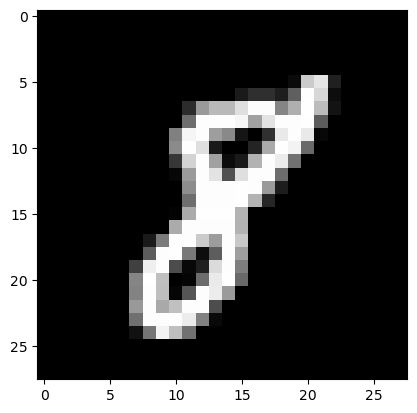

In [80]:
#An example of an image and its label

n = 17
img = np.rint(images[n].reshape(28,28))
plt.imshow(img, cmap="gray")
print(labels[n])

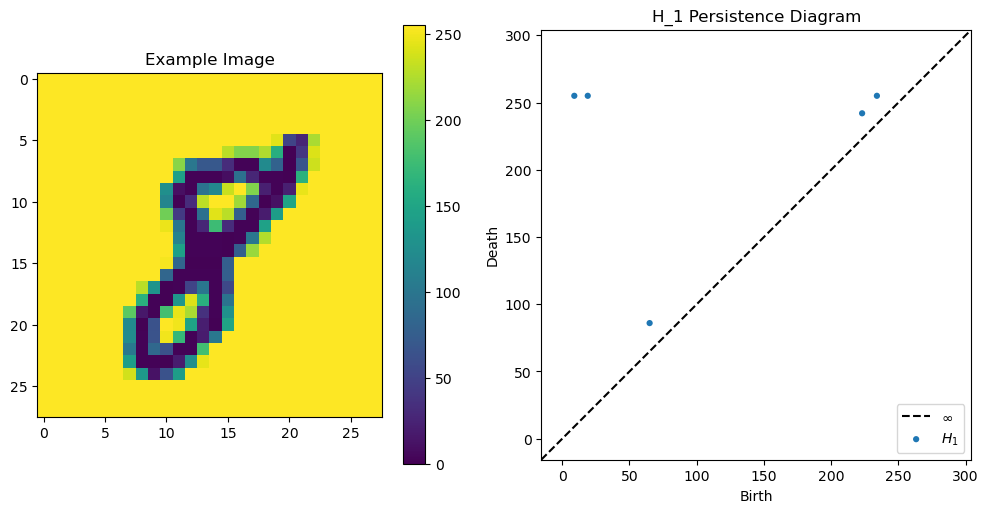

List of lifetimes: [ 21.  19.  21. 236. 246.]


In [81]:
#Calculate persistence diagram of the example image

neg_img = 255-img #invert the image so the number is dark. This way it is captured in the low sublevelsets. 

dgm = lower_star_img_new(neg_img) #calculates the H_0 and H_1 persistence diagrams of the sublevelset filtration
dgm0 = dgm[0] #H_0 diagram
dgm1 = dgm[1] #H_1 diagram

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(neg_img)
plt.colorbar()
plt.title("Example Image")

plt.subplot(122)
plot_diagrams(dgm1)
plt.title("H_1 Persistence Diagram")
plt.legend(["$\infty$","$H_1$"], loc = 4)

plt.tight_layout()
plt.show()

print('List of lifetimes: ' + str(dgm[1][:,1] - dgm[1][:,0])) #list of life times of each point

Remember that the points $(b,d)$ in the PD with long lifetimes (i.e. those where $d-b$ is large) are the most significant. For example, in the 1-D PD for the digit 8 above, there are two points with lifetimes around 240 that are significantly longer than the others. Each of those points correspond to one of the two loops that form the 8. 

In [82]:
#Loop over images and run lower_star_img_new() to make lists of persistence diagrams 
#and lifetimes (death time - birth time)

dgm_list = []
LT1_list = []

N = 10000 #Take first N MNIST images. 10,000 max.
for n in range(N):
    img = np.rint(images[n].reshape(28,28))
    neg_img = 255-img #want the number to be dark so it is captured in the sublevelsets 

    dgm = lower_star_img_new(neg_img)
    
    #store lifetimes of each H_1 point
    LT1_list.append(dgm[1][:,1] - dgm[1][:,0])
    
    #store dgm's
    dgm_list.append(dgm)

print('Done!')

Done!


In [83]:
#modify lifetimes list to isolate the long lifetimes to classify images

LT1_mod_list = []
p = .1 #elimate lifetimes that are not within 10% of max lifetime
q = 50 #elimate lifetimes that are smaller than 50
        
for i in range(len(LT1_list)):    
    if len(LT1_list[i]) != 0:
        temp_max = np.max(LT1_list[i])
        
        bln = (np.abs(LT1_list[i] - temp_max)/temp_max < p) & (LT1_list[i] > q) #boolean
        
        LT1_mod = LT1_list[i][bln]
        LT1_mod_list.append([LT1_mod,labels[i],i])

In [84]:
#sorts the digits that have 0,1,2, or some other number of significant points in their persistence diagrams

LT1_0D = []
LT1_1D = []
LT1_2D = []
LT1_else = []

#Find H_1 PD with zero points
for i in range(len(LT1_list)):
    if len(LT1_list[i]) == 0:
        LT1_0D.append([LT1_list[i],labels[i],i])

#Find and sort H_1 PDs with 1,2, or 3+ points
for i in range(len(LT1_mod_list)):
    if len(LT1_mod_list[i][0]) == 1:
        LT1_1D.append(LT1_mod_list[i])
    elif len(LT1_mod_list[i][0]) == 2:
        LT1_2D.append(LT1_mod_list[i])
    else:
        LT1_else.append(LT1_mod_list[i])

Number of digits sorted into each bin: (4469, 4101, 452, 978)
All the images made it!


Text(0, 0.5, 'Number of Digits')

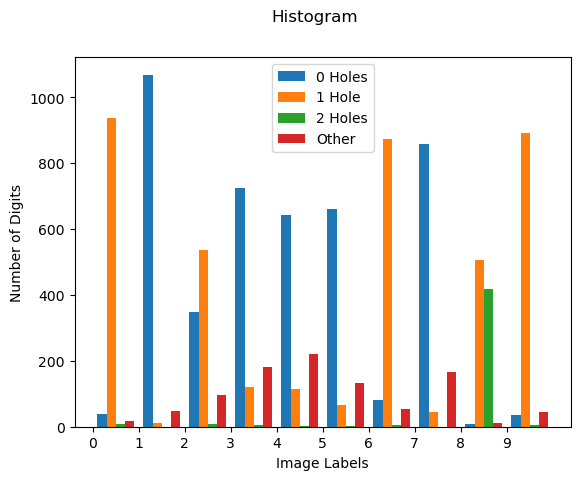

In [85]:
#Makes histograms of the results of the sorting

#Sanity checks
print('Number of digits sorted into each bin: ' + str((len(LT1_0D), len(LT1_1D), len(LT1_2D), len(LT1_else))))
if N == len(LT1_0D) + len(LT1_1D) + len(LT1_2D) + len(LT1_else):
    print('All the images made it!')
else:
    print('Something went wrong!')

#Select labels from each category for plotting
Labels_0D = []
for item in LT1_0D:
    Labels_0D.append(item[1])

Labels_1D = []
for item in LT1_1D:
    Labels_1D.append(item[1])

Labels_2D = []
for item in LT1_2D:
    Labels_2D.append(item[1])
    
Labels_Other = []
for item in LT1_else:
    Labels_Other.append(item[1])
    
#plot histogram
fig, ax1 = plt.subplots(1, 1)
fig.suptitle('Histogram')

ax1.hist([Labels_0D,Labels_1D,Labels_2D,Labels_Other], bins = [0,1,2,3,4,5,6,7,8,9,10])
ax1.set_xticks(range(10))
ax1.legend(['0 Holes','1 Hole','2 Holes','Other'])
plt.xlabel('Image Labels')
plt.ylabel('Number of Digits')

Conclusion:

The above histogram shows that the TDA methods used correctly classifies much of the data set based on $H_1$ PDs. 

Note that 0,1,4,5,6,7,9 are the most sucessful cases because the majority of those digits have the expected homology. The digits 2 and 8 have an honest mix of homologies. In the case of the 2 this is likely because the 2 is often drawn without a loop. The case of the 8 is interesting because a slight majority of the 8's have a 1-dimensional homology group, while you expect them to be 2-dimensional. This is most likely due to one of the loops is an elongated and squished circle, which is effectively a line.

The MNIST database is a reletively simple data set. If you wanted to do a similar analysis of a more complicated data set, you could compute PDs then vectorize them using persistence curves. At this point you have a variety of data analysis tools at your disposal. This has been done for data sets of skin legions to identify skin cancer: https://ieeexplore.ieee.org/document/8622175.